In [1]:
from music21 import converter, note, instrument, chord

def extract_notes(midi_path):
    midi = converter.parse(midi_path)
    notes = []

    parts = instrument.partitionByInstrument(midi)

    if parts:
        for p in parts.parts:
            if 'Piano' in str(p):
                for element in p.recurse():
                    if isinstance(element, note.Note):
                        notes.append(str(element.pitch))
                    if isinstance(element, chord.Chord):
                        notes.append('.'.join(str(n) for n in element.normalOrder))
                break

    else:
        for element in midi.flat.notes:
            if isinstance(element, note.Note):
                notes.append(str(element.pitch))
            if isinstance(element, chord.Chord):
                notes.appaned('.'.join(str(n) for n in element.normalOrder))

    return notes

In [2]:
import os
all_notes = []

midi_dir = 'midi'
midi_files = os.listdir(midi_dir)

for file in midi_files:
    midi_file = os.path.join(midi_dir, file)
    notes = extract_notes(midi_file)
    all_notes.extend(notes)

print(f"Total notes collected: {len(all_notes)}")

Total notes collected: 1965


In [3]:
import numpy as np

unique_notes = set(all_notes)
seq_length = 50

note2int = {note: i for i, note in enumerate(unique_notes)}
encoded = [note2int[n] for n in notes]

X = []
y = []

for i in range(len(encoded) - seq_length):
    X.append(encoded[i : i + seq_length])
    y.append(encoded[i + seq_length])

In [4]:
import torch 
from torch.utils.data import DataLoader, Dataset

num_vocab = len(set(all_notes))

X_tensor = torch.tensor(X, dtype=torch.long)
y_tensor = torch.tensor(y, dtype=torch.long)

class MusicDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = MusicDataset(X_tensor, y_tensor)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

In [5]:
import torch.nn as nn

class MusicLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size, num_layers):
        super(MusicLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_size, num_layers, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.lstm(x)
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out

model = MusicLSTM(vocab_size=num_vocab, embed_dim=100, hidden_size=512, num_layers=3)

In [6]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_values = []

for epoch in range(100):
    model.train()
    total_loss = 0
    for batch_x, batch_y in loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
    loss_values.append(total_loss)
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

Epoch 1, Loss: 37.6068
Epoch 2, Loss: 30.8608
Epoch 3, Loss: 31.1603
Epoch 4, Loss: 29.9974
Epoch 5, Loss: 28.8324
Epoch 6, Loss: 29.1085
Epoch 7, Loss: 26.7567
Epoch 8, Loss: 25.4080
Epoch 9, Loss: 24.1406
Epoch 10, Loss: 23.2369
Epoch 11, Loss: 21.7100
Epoch 12, Loss: 20.9223
Epoch 13, Loss: 20.4310
Epoch 14, Loss: 19.6599
Epoch 15, Loss: 18.5918
Epoch 16, Loss: 16.9869
Epoch 17, Loss: 16.7792
Epoch 18, Loss: 15.5268
Epoch 19, Loss: 14.6901
Epoch 20, Loss: 13.3494
Epoch 21, Loss: 12.7680
Epoch 22, Loss: 11.6001
Epoch 23, Loss: 10.6191
Epoch 24, Loss: 9.5150
Epoch 25, Loss: 9.8849
Epoch 26, Loss: 9.2369
Epoch 27, Loss: 8.2563
Epoch 28, Loss: 7.7127
Epoch 29, Loss: 6.5054
Epoch 30, Loss: 5.7001
Epoch 31, Loss: 6.0342
Epoch 32, Loss: 5.5253
Epoch 33, Loss: 5.3168
Epoch 34, Loss: 4.8932
Epoch 35, Loss: 3.8993
Epoch 36, Loss: 4.0001
Epoch 37, Loss: 4.3050
Epoch 38, Loss: 3.8751
Epoch 39, Loss: 3.4881
Epoch 40, Loss: 3.8242
Epoch 41, Loss: 3.5279
Epoch 42, Loss: 3.2659
Epoch 43, Loss: 3.17

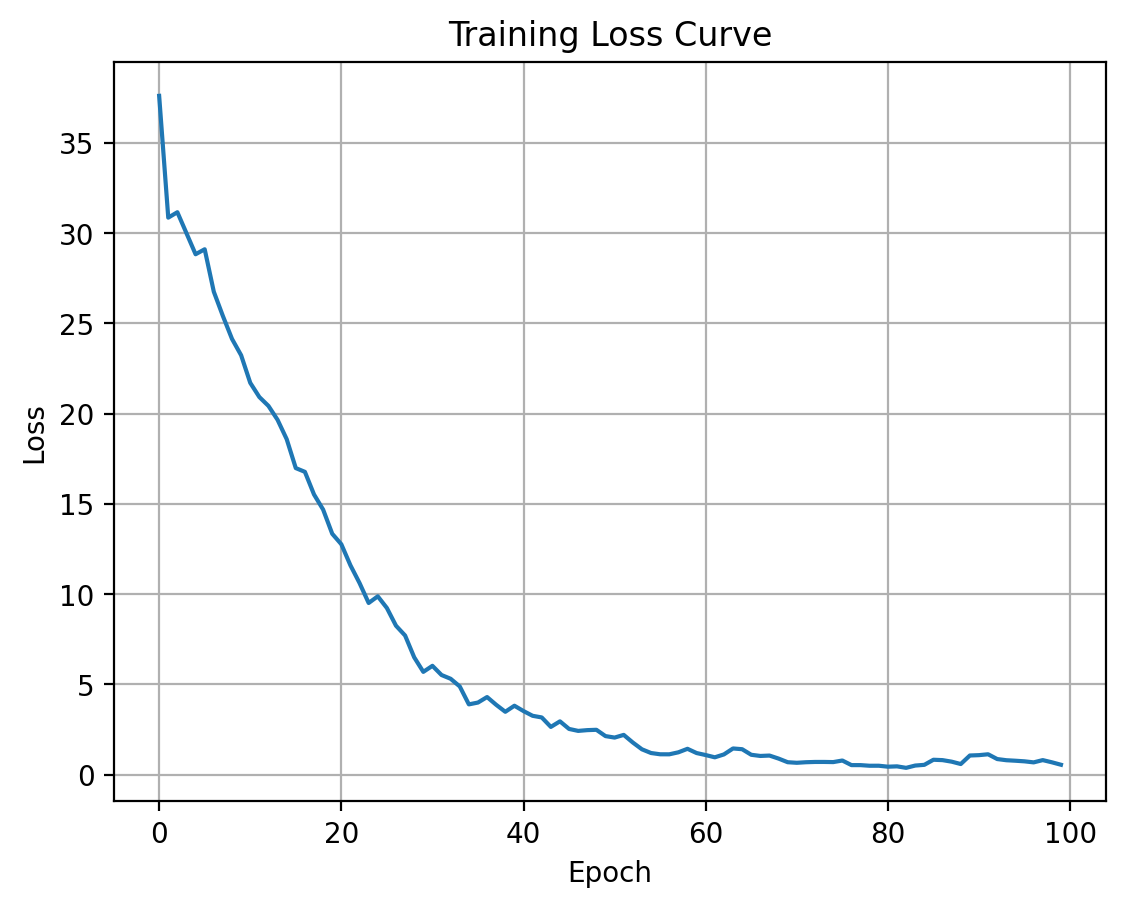

In [7]:
import matplotlib.pyplot as plt
plt.plot(loss_values)  
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.show()

In [8]:
torch.save(model.state_dict(), "lstm_music_model.pt")

In [9]:
int2note = {i: n for n, i in note2int.items()}

In [10]:
import random
import torch.nn.functional as F

start_idx = 0
seed_seq = X[start_idx]

model.eval()

generated = seed_seq.copy()
input_seq = torch.tensor(seed_seq, dtype=torch.long).unsqueeze(0).to(device)

for _ in range(500):
    with torch.no_grad():
        output = model(input_seq)
        temperature = 0.7
        probs = F.softmax(output / temperature, dim=1)
        predicted_idx = torch.multinomial(probs, num_samples=1).item()

    generated.append(predicted_idx)
    input_seq = torch.tensor(generated[-seq_length : ], dtype=torch.long).unsqueeze(0).to(device)

In [11]:
generated_notes = [int2note[i] for i in generated]
print(generated_notes[:50])

['C6', 'C#6', 'C6', 'C#6', 'C6', 'C#6', 'C6', 'B-5', 'G#5', 'G#5', 'B-5', 'G#5', 'G#5', 'B-5', 'G#5', 'B-5', 'G#5', 'G5', 'F5', 'F5', 'G5', 'F5', 'G5', 'F5', 'G5', 'F5', 'E-5', 'C#5', 'C5', 'C5', 'C5', 'C#5', 'C5', 'C#5', 'C5', 'C#5', 'C#5', 'C5', 'B-4', 'G#4', 'G#4', 'B-4', 'G#4', 'B-4', 'G#4', 'B-4', 'G#4', 'G4', 'F4', 'F4']


In [12]:
from music21 import stream

output_stream = stream.Stream()

for pitch in generated_notes:
    if '.' in pitch or pitch.isdigit():
        chord_notes = [int(n) for n in pitch.split('.')]
        new_chord = chord.Chord(chord_notes)
        new_chord.quarterLength = 0.5
        output_stream.append(new_chord)
    else:
        new_note = note.Note(pitch)
        new_note.quarterLength = 0.5
        output_stream.append(new_note)

output_stream.write('midi', fp='generated_audio.mid')
converter.parse("generated_audio.mid").show('midi')

In [13]:
from midi2audio import FluidSynth

fs = FluidSynth(sound_font="FluidR3_GM.sf2")  
fs.midi_to_audio("generated_audio.mid", "generated_audio.wav")

FluidSynth runtime version 2.4.6
Copyright (C) 2000-2025 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file 'generated_audio.wav'..


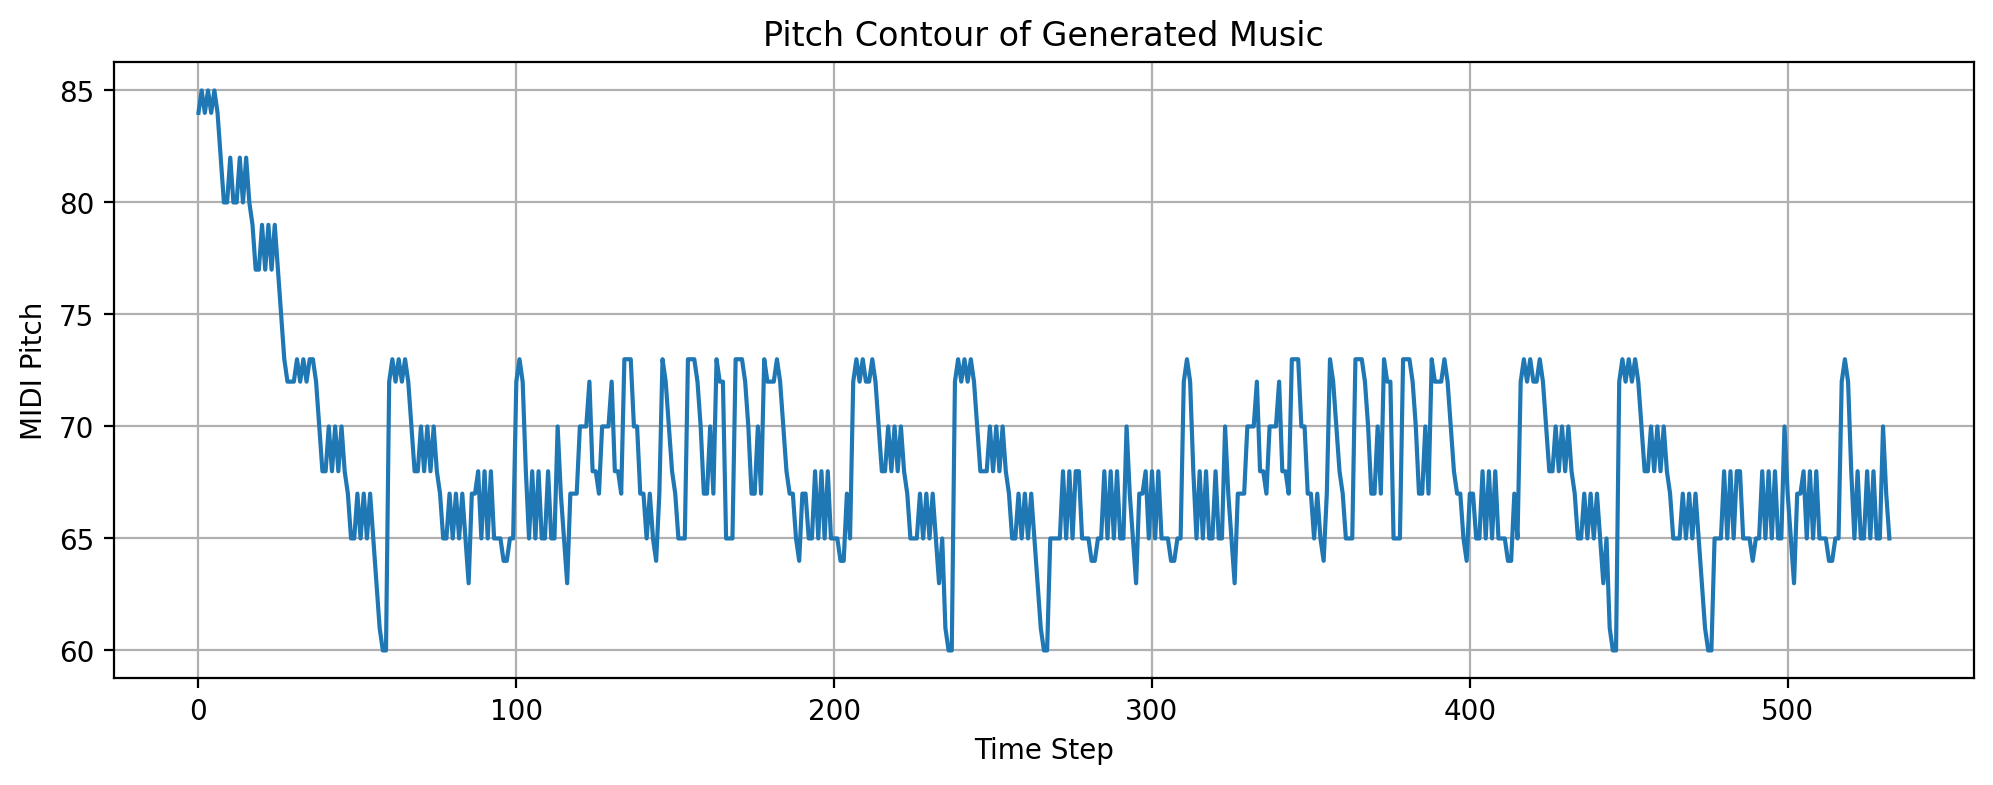

In [14]:
from music21 import pitch
import matplotlib.pyplot as plt

pitches = [pitch.Pitch(n).midi for n in generated_notes if '.' not in n and n.isdigit() is False]

plt.figure(figsize=(12, 4))
plt.plot(pitches)
plt.title("Pitch Contour of Generated Music")
plt.xlabel("Time Step")
plt.ylabel("MIDI Pitch")
plt.grid(True)
plt.show()

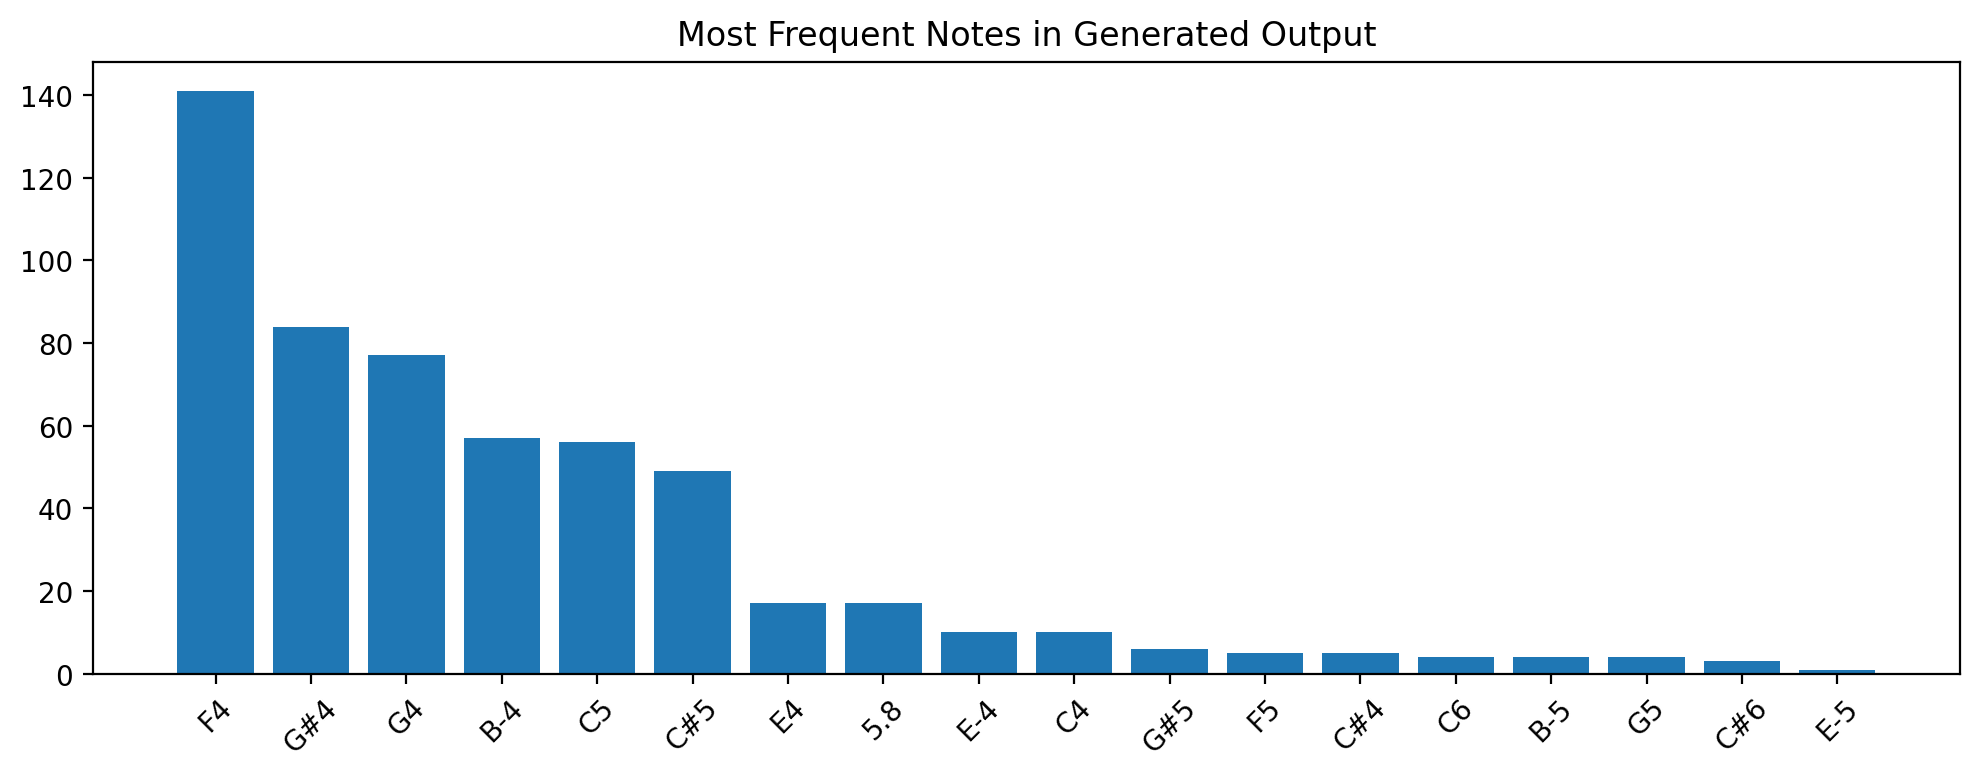

In [15]:
from collections import Counter

counts = Counter(generated_notes)
top_notes = counts.most_common(20)

labels, values = zip(*top_notes)
plt.figure(figsize=(10, 4))
plt.bar(labels, values)
plt.title("Most Frequent Notes in Generated Output")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()